In [408]:
from pyspark.sql import SparkSession
# from pyspark.sql.functions import *
from pyspark.sql import functions as f
from functools import reduce
from pyspark.sql.types import IntegerType, FloatType, StringType
from pyspark.sql.functions import lit, udf, expr, concat, col

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [409]:
spark = (SparkSession
         .builder
         .appName("Parkinson")
         .getOrCreate())
df = spark.read.option('header', 'true').csv('dataset.csv')

## Information of dataframe

In [410]:
df.printSchema()

root
 |--  Participant  code : string (nullable = true)
 |--  Age  (years) : string (nullable = true)
 |-- Gender: string (nullable = true)
 |--  Positive  history  of  Parkinson  disease  in  family : string (nullable = true)
 |--  Age  of  disease  onset  (years) : string (nullable = true)
 |--  Duration  of  disease  from  first  symptoms  (years) : string (nullable = true)
 |--  Antidepressant  therapy : string (nullable = true)
 |--  Antiparkinsonian  medication : string (nullable = true)
 |--  Antipsychotic  medication : string (nullable = true)
 |--  Benzodiazepine  medication : string (nullable = true)
 |--  Levodopa  equivalent  (mg/day) : string (nullable = true)
 |--  Clonazepam  (mg/day) : string (nullable = true)
 |--  Overview  of  motor  examination:  Hoehn  &  Yahr  scale  (-) : string (nullable = true)
 |--  Overview  of  motor  examination:  UPDRS  III  total  (-) : string (nullable = true)
 |--  18.  Speech : string (nullable = true)
 |--  19.  Facial  Expression : s

In [411]:
df.show()

+-------------------+--------------+------+-------------------------------------------------------+----------------------------------+-------------------------------------------------------+-------------------------+------------------------------+---------------------------+----------------------------+--------------------------------+----------------------+---------------------------------------------------------------+-----------------------------------------------------------+-------------+-------------------------+--------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------------------+-------------------------------------------+------------------------+-----------------------+-----------------------+-----------------------+-----------------------+-------------------------+-------------------------+------------------------------+-----------------------

In [412]:
df.toPandas()

,Participant code,Age (years),Gender,Positive history of Parkinson disease in family,Age of disease onset (years),Duration of disease from first symptoms (years),Antidepressant therapy,Antiparkinsonian medication,Antipsychotic medication,Benzodiazepine medication,...,Acceleration of speech timing (-/min2) 55,Duration of pause intervals (ms) 56,Duration of voiced intervals (ms) 57,Gaping in-between voiced Intervals (-/min) 58,Duration of unvoiced stops (ms) 59,Decay of unvoiced fricatives (‰/min) 60,Relative loudness of respiration (dB) 61,Pause intervals per respiration (-) 62,Rate of speech respiration (-/min) 63,Latency of respiratory exchange (ms) 64
0,PD01,58,F,No,56,2,No,No,No,No,...,-2.82,158,318,49.01,22.37,0.588,-19.77,6,13.81,127
1,PD02,68,F,No,67,1,No,No,No,No,...,8.2,295,264,40.56,26.88,-0.825,-23.26,4,21.77,313
2,PD03,68,M,No,67,1,No,No,No,No,...,4.71,280,317,48.97,22.37,-0.955,-13.29,4,22.52,201
3,PD04,75,M,No,73,2,No,No,No,No,...,-9.09,397,800,18.69,49.37,0.791,-25.08,2,14.37,151
4,PD05,61,M,Yes,60,0.7,No,No,No,No,...,11.77,206,480,33.54,26.87,0.075,-22.32,5,14.61,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,HC46,69,M,-,-,-,No,No,No,No,...,8.43,264,380,36.36,26.88,0.023,-23.12,3,15.41,177
126,HC47,68,M,-,-,-,No,No,No,No,...,4.09,177,359,47.06,22.37,-0.117,-18.67,5,16.94,138
127,HC48,53,M,-,-,-,No,No,No,No,...,5.09,223,391,37.74,40.37,0.411,-15.56,3,19.51,156
128,HC49,44,M,-,-,-,No,No,No,No,...,2.8,252,361,38.92,26.88,0.389,-17.53,4,17.51,154


## Transformation of dataframe 


In [413]:
#creation of new list without left and right spaces
current_columns = df.columns
modified_columns = [col.strip() for col in current_columns]
modified_columns

['Participant  code',
 'Age  (years)',
 'Gender',
 'Positive  history  of  Parkinson  disease  in  family',
 'Age  of  disease  onset  (years)',
 'Duration  of  disease  from  first  symptoms  (years)',
 'Antidepressant  therapy',
 'Antiparkinsonian  medication',
 'Antipsychotic  medication',
 'Benzodiazepine  medication',
 'Levodopa  equivalent  (mg/day)',
 'Clonazepam  (mg/day)',
 'Overview  of  motor  examination:  Hoehn  &  Yahr  scale  (-)',
 'Overview  of  motor  examination:  UPDRS  III  total  (-)',
 '18.  Speech',
 '19.  Facial  Expression',
 '20.  Tremor  at  Rest  -  head',
 '20.  Tremor  at  Rest  -  RUE',
 '20.  Tremor  at  Rest  -  LUE',
 '20.  Tremor  at  Rest  -  RLE',
 '20.  Tremor  at  Rest  -  LLE',
 '21.  Action  or  Postural  Tremor  -  RUE',
 '21.  Action  or  Postural  Tremor  -  LUE',
 '22.  Rigidity  -  neck',
 '22.  Rigidity  -  RUE',
 '22.  Rigidity  -  LUE',
 '22.  Rigidity  -  RLE',
 '22.  Rigidity  -  LLE',
 '23.Finger  Taps  -  RUE',
 '23.Finger  Taps  - 

In [414]:
#removing unnecessary numbers and signs
for col in modified_columns:
    char_first = col[:2]
    char_last = col[-2:]
    if char_first.isdigit():
        col_index = modified_columns.index(col)
        modified_columns[col_index] = col.replace(char_first + '.', "")
    elif char_last.isdigit():
        col_index = modified_columns.index(col)
        modified_columns[col_index] = col.replace(char_last,"")
    else:
        continue
modified_columns

['Participant  code',
 'Age  (years)',
 'Gender',
 'Positive  history  of  Parkinson  disease  in  family',
 'Age  of  disease  onset  (years)',
 'Duration  of  disease  from  first  symptoms  (years)',
 'Antidepressant  therapy',
 'Antiparkinsonian  medication',
 'Antipsychotic  medication',
 'Benzodiazepine  medication',
 'Levodopa  equivalent  (mg/day)',
 'Clonazepam  (mg/day)',
 'Overview  of  motor  examination:  Hoehn  &  Yahr  scale  (-)',
 'Overview  of  motor  examination:  UPDRS  III  total  (-)',
 '  Speech',
 '  Facial  Expression',
 '  Tremor  at  Rest  -  head',
 '  Tremor  at  Rest  -  RUE',
 '  Tremor  at  Rest  -  LUE',
 '  Tremor  at  Rest  -  RLE',
 '  Tremor  at  Rest  -  LLE',
 '  Action  or  Postural  Tremor  -  RUE',
 '  Action  or  Postural  Tremor  -  LUE',
 '  Rigidity  -  neck',
 '  Rigidity  -  RUE',
 '  Rigidity  -  LUE',
 '  Rigidity  -  RLE',
 '  Rigidity  -  LLE',
 'Finger  Taps  -  RUE',
 'Finger  Taps  -  LUE',
 '  Hand  Movements  -  RUE',
 '  Hand  M

In [415]:
#creation of new list withouе left and right spaces
modified_columns_2 = [col.strip() for col in modified_columns]
modified_columns_2

['Participant  code',
 'Age  (years)',
 'Gender',
 'Positive  history  of  Parkinson  disease  in  family',
 'Age  of  disease  onset  (years)',
 'Duration  of  disease  from  first  symptoms  (years)',
 'Antidepressant  therapy',
 'Antiparkinsonian  medication',
 'Antipsychotic  medication',
 'Benzodiazepine  medication',
 'Levodopa  equivalent  (mg/day)',
 'Clonazepam  (mg/day)',
 'Overview  of  motor  examination:  Hoehn  &  Yahr  scale  (-)',
 'Overview  of  motor  examination:  UPDRS  III  total  (-)',
 'Speech',
 'Facial  Expression',
 'Tremor  at  Rest  -  head',
 'Tremor  at  Rest  -  RUE',
 'Tremor  at  Rest  -  LUE',
 'Tremor  at  Rest  -  RLE',
 'Tremor  at  Rest  -  LLE',
 'Action  or  Postural  Tremor  -  RUE',
 'Action  or  Postural  Tremor  -  LUE',
 'Rigidity  -  neck',
 'Rigidity  -  RUE',
 'Rigidity  -  LUE',
 'Rigidity  -  RLE',
 'Rigidity  -  LLE',
 'Finger  Taps  -  RUE',
 'Finger  Taps  -  LUE',
 'Hand  Movements  -  RUE',
 'Hand  Movements  -  LUE',
 'Rapid  Alte

In [416]:
#creation of new list replacing spaces to '_'
final_columns = list(map(lambda item : item.replace("  ","_"),modified_columns_2)) 
final_columns

['Participant_code',
 'Age_(years)',
 'Gender',
 'Positive_history_of_Parkinson_disease_in_family',
 'Age_of_disease_onset_(years)',
 'Duration_of_disease_from_first_symptoms_(years)',
 'Antidepressant_therapy',
 'Antiparkinsonian_medication',
 'Antipsychotic_medication',
 'Benzodiazepine_medication',
 'Levodopa_equivalent_(mg/day)',
 'Clonazepam_(mg/day)',
 'Overview_of_motor_examination:_Hoehn_&_Yahr_scale_(-)',
 'Overview_of_motor_examination:_UPDRS_III_total_(-)',
 'Speech',
 'Facial_Expression',
 'Tremor_at_Rest_-_head',
 'Tremor_at_Rest_-_RUE',
 'Tremor_at_Rest_-_LUE',
 'Tremor_at_Rest_-_RLE',
 'Tremor_at_Rest_-_LLE',
 'Action_or_Postural_Tremor_-_RUE',
 'Action_or_Postural_Tremor_-_LUE',
 'Rigidity_-_neck',
 'Rigidity_-_RUE',
 'Rigidity_-_LUE',
 'Rigidity_-_RLE',
 'Rigidity_-_LLE',
 'Finger_Taps_-_RUE',
 'Finger_Taps_-_LUE',
 'Hand_Movements_-_RUE',
 'Hand_Movements_-_LUE',
 'Rapid_Alternating_Movements_-_RUE',
 'Rapid_Alternating_Movements_-_LUE',
 'Leg_Agility_-_RLE',
 'Leg_Ag

In [417]:
final_df = reduce(lambda data, idx: data.withColumnRenamed(current_columns[idx], final_columns[idx]), range(len(current_columns)), df)
final_df.printSchema()

root
 |-- Participant_code: string (nullable = true)
 |-- Age_(years): string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Positive_history_of_Parkinson_disease_in_family: string (nullable = true)
 |-- Age_of_disease_onset_(years): string (nullable = true)
 |-- Duration_of_disease_from_first_symptoms_(years): string (nullable = true)
 |-- Antidepressant_therapy: string (nullable = true)
 |-- Antiparkinsonian_medication: string (nullable = true)
 |-- Antipsychotic_medication: string (nullable = true)
 |-- Benzodiazepine_medication: string (nullable = true)
 |-- Levodopa_equivalent_(mg/day): string (nullable = true)
 |-- Clonazepam_(mg/day): string (nullable = true)
 |-- Overview_of_motor_examination:_Hoehn_&_Yahr_scale_(-): string (nullable = true)
 |-- Overview_of_motor_examination:_UPDRS_III_total_(-): string (nullable = true)
 |-- Speech: string (nullable = true)
 |-- Facial_Expression: string (nullable = true)
 |-- Tremor_at_Rest_-_head: string (nullable = true)
 |--

In [418]:
park_anamnesis = final_df.select('Participant_code', 
                                'Age_(years)', 
                                'Gender', 
                                'Positive_history_of_Parkinson_disease_in_family', 
                                'Age_of_disease_onset_(years)'
                               )
park_anamnesis.printSchema()

root
 |-- Participant_code: string (nullable = true)
 |-- Age_(years): string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Positive_history_of_Parkinson_disease_in_family: string (nullable = true)
 |-- Age_of_disease_onset_(years): string (nullable = true)



In [419]:
park_symptoms = final_df.select('Participant_code', 
                                'Speech',
                               'Hand_Movements_-_RUE',
                               'Tremor_at_Rest_-_head')
park_symptoms.printSchema()

root
 |-- Participant_code: string (nullable = true)
 |-- Speech: string (nullable = true)
 |-- Hand_Movements_-_RUE: string (nullable = true)
 |-- Tremor_at_Rest_-_head: string (nullable = true)



## Data Analyzing

In [420]:
park_anamnesis.show()

+----------------+-----------+------+-----------------------------------------------+----------------------------+
|Participant_code|Age_(years)|Gender|Positive_history_of_Parkinson_disease_in_family|Age_of_disease_onset_(years)|
+----------------+-----------+------+-----------------------------------------------+----------------------------+
|            PD01|         58|     F|                                             No|                          56|
|            PD02|         68|     F|                                             No|                          67|
|            PD03|         68|     M|                                             No|                          67|
|            PD04|         75|     M|                                             No|                          73|
|            PD05|         61|     M|                                            Yes|                          60|
|            PD06|         58|     M|                                           

In [421]:
#converting string type of colemn Age to integer
park_anamnesis = park_anamnesis.withColumn("Age",park_anamnesis["Age_(years)"].cast(IntegerType()))
park_anamnesis = park_anamnesis.withColumn("Age_of_disease_onset",park_anamnesis["Age_of_disease_onset_(years)"].cast(IntegerType()))
park_anamnesis.printSchema()

root
 |-- Participant_code: string (nullable = true)
 |-- Age_(years): string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Positive_history_of_Parkinson_disease_in_family: string (nullable = true)
 |-- Age_of_disease_onset_(years): string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Age_of_disease_onset: integer (nullable = true)



### What is the average age for Parkinson's disease?

In [422]:
park_anamnesis.groupBy('Gender').mean('Age').show()

+------+-----------------+
|Gender|         avg(Age)|
+------+-----------------+
|     F|66.37037037037037|
|     M|63.79611650485437|
+------+-----------------+



### Who suffers from the disease more often: men or women?

In [423]:
park_anamnesis.groupBy('Gender').count().show()

+------+-----+
|Gender|count|
+------+-----+
|     F|   27|
|     M|  103|
+------+-----+



### What percentage of patients had a family history of Parkinson's disease for each gender?

In [424]:
park_anamnesis.groupBy('Gender').count().show()

+------+-----+
|Gender|count|
+------+-----+
|     F|   27|
|     M|  103|
+------+-----+



In [425]:
female_amount = park_anamnesis.filter(park_anamnesis.Gender == 'F').count()
female_amount

27

In [426]:
male_amount = park_anamnesis.filter(park_anamnesis.Gender == 'M').count()
male_amount

103

In [427]:
male_positive_history = (park_anamnesis
.filter(park_anamnesis.Gender == 'M')
.filter(park_anamnesis.Positive_history_of_Parkinson_disease_in_family == 'Yes')
                 .count())


male_positive_history

2

In [428]:
female_positive_history = (park_anamnesis
.filter(park_anamnesis.Gender == 'F')
.filter(park_anamnesis.Positive_history_of_Parkinson_disease_in_family == 'Yes')
                 .count())


female_positive_history

1

In [429]:
male_percent = male_positive_history/male_amount*100
female_percent = female_positive_history/female_amount*100
male_percent


1.9417475728155338

In [430]:
female_percent

3.7037037037037033

### How many years have the disease?


In [431]:
park_anamnesis = park_anamnesis.withColumn("disease_duration", (f.col('Age') - f.col('Age_of_disease_onset')))
park_anamnesis.select('Gender','disease_duration').show()

+------+----------------+
|Gender|disease_duration|
+------+----------------+
|     F|               2|
|     F|               1|
|     M|               1|
|     M|               2|
|     M|               1|
|     M|               0|
|     M|               1|
|     F|               2|
|     M|               1|
|     M|               1|
|     M|               1|
|     F|               5|
|     M|               6|
|     M|               1|
|     F|               2|
|     F|               1|
|     F|               2|
|     M|               1|
|     M|               4|
|     M|               1|
+------+----------------+
only showing top 20 rows



### What medicine is common among female patients?

In [432]:
#create new datafreme with medicine
park_medicine = final_df.select('Participant_code', 
                                'Antidepressant_therapy',
                               'Antiparkinsonian_medication',
                               'Antipsychotic_medication',
                               'Benzodiazepine_medication',
                               'Levodopa_equivalent_(mg/day)',
                               'Clonazepam_(mg/day)')
park_medicine.printSchema()


root
 |-- Participant_code: string (nullable = true)
 |-- Antidepressant_therapy: string (nullable = true)
 |-- Antiparkinsonian_medication: string (nullable = true)
 |-- Antipsychotic_medication: string (nullable = true)
 |-- Benzodiazepine_medication: string (nullable = true)
 |-- Levodopa_equivalent_(mg/day): string (nullable = true)
 |-- Clonazepam_(mg/day): string (nullable = true)



In [433]:
#rename columns
park_medicine = park_medicine.withColumnRenamed('Levodopa_equivalent_(mg/day)', 'Levodopa_equivalent')\
.withColumnRenamed('Clonazepam_(mg/day)', 'Clonazepam')
park_medicine.printSchema()

root
 |-- Participant_code: string (nullable = true)
 |-- Antidepressant_therapy: string (nullable = true)
 |-- Antiparkinsonian_medication: string (nullable = true)
 |-- Antipsychotic_medication: string (nullable = true)
 |-- Benzodiazepine_medication: string (nullable = true)
 |-- Levodopa_equivalent: string (nullable = true)
 |-- Clonazepam: string (nullable = true)



In [434]:
female_dataset = park_anamnesis.filter(f.col('Gender')=='F')

In [435]:
female_medicine = female_dataset.join(park_medicine, on='Participant_code').printSchema()

root
 |-- Participant_code: string (nullable = true)
 |-- Age_(years): string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Positive_history_of_Parkinson_disease_in_family: string (nullable = true)
 |-- Age_of_disease_onset_(years): string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Age_of_disease_onset: integer (nullable = true)
 |-- disease_duration: integer (nullable = true)
 |-- Antidepressant_therapy: string (nullable = true)
 |-- Antiparkinsonian_medication: string (nullable = true)
 |-- Antipsychotic_medication: string (nullable = true)
 |-- Benzodiazepine_medication: string (nullable = true)
 |-- Levodopa_equivalent: string (nullable = true)
 |-- Clonazepam: string (nullable = true)



In [436]:
female_medicine = female_dataset.join(park_medicine, on='Participant_code')
female_medicine.show()

+----------------+-----------+------+-----------------------------------------------+----------------------------+---+--------------------+----------------+----------------------+---------------------------+------------------------+-------------------------+-------------------+----------+
|Participant_code|Age_(years)|Gender|Positive_history_of_Parkinson_disease_in_family|Age_of_disease_onset_(years)|Age|Age_of_disease_onset|disease_duration|Antidepressant_therapy|Antiparkinsonian_medication|Antipsychotic_medication|Benzodiazepine_medication|Levodopa_equivalent|Clonazepam|
+----------------+-----------+------+-----------------------------------------------+----------------------------+---+--------------------+----------------+----------------------+---------------------------+------------------------+-------------------------+-------------------+----------+
|            PD01|         58|     F|                                             No|                          56| 58|            

In [437]:
female_medicine.select('Antidepressant_therapy',
                        'Antiparkinsonian_medication',
                        'Antipsychotic_medication',
                       'Benzodiazepine_medication',
                       'Levodopa_equivalent',
                       'Clonazepam').show()

+----------------------+---------------------------+------------------------+-------------------------+-------------------+----------+
|Antidepressant_therapy|Antiparkinsonian_medication|Antipsychotic_medication|Benzodiazepine_medication|Levodopa_equivalent|Clonazepam|
+----------------------+---------------------------+------------------------+-------------------------+-------------------+----------+
|                    No|                         No|                      No|                       No|                  0|         0|
|                    No|                         No|                      No|                       No|                  0|         0|
|       Yes  (Aurorix) |                         No|                      No|                       No|                  0|         0|
|                    No|                         No|                      No|                       No|                  0|         0|
|                    No|                         No|   

In [438]:
unPivotDF = female_medicine.select("Participant_code",
                                   expr("""stack(6, 'Antidepressant_therapy', Antidepressant_therapy, 
                                        'Antiparkinsonian_medication', Antiparkinsonian_medication, 
                                        'Benzodiazepine_medication', Benzodiazepine_medication,
                                        'Levodopa_equivalent', Levodopa_equivalent,
                                        'Clonazepam', Clonazepam
                                        ) as (Medcine,Total)"""))
unPivotDF = unPivotDF.na.replace('No', '0').na.fill(value='0', subset=["Total"])
unPivotDF.show()

+----------------+--------------------+----------------+
|Participant_code|             Medcine|           Total|
+----------------+--------------------+----------------+
|            PD01|Antidepressant_th...|               0|
|            PD01|Antiparkinsonian_...|               0|
|            PD01|Benzodiazepine_me...|               0|
|            PD01| Levodopa_equivalent|               0|
|            PD01|          Clonazepam|               0|
|            PD01|                null|               0|
|            PD02|Antidepressant_th...|               0|
|            PD02|Antiparkinsonian_...|               0|
|            PD02|Benzodiazepine_me...|               0|
|            PD02| Levodopa_equivalent|               0|
|            PD02|          Clonazepam|               0|
|            PD02|                null|               0|
|            PD08|Antidepressant_th...| Yes  (Aurorix) |
|            PD08|Antiparkinsonian_...|               0|
|            PD08|Benzodiazepin

In [439]:
medcine_df = unPivotDF.filter(f.col('Total') != '0').groupBy('Medcine').count()
medcine_df.show()

+--------------------+-----+
|             Medcine|count|
+--------------------+-----+
|          Clonazepam|    5|
|Benzodiazepine_me...|    6|
|Antidepressant_th...|    3|
+--------------------+-----+



In [440]:
medcine_df.printSchema()

root
 |-- Medcine: string (nullable = true)
 |-- count: long (nullable = false)



Text(0, 0.5, 'Total amount of medcine')

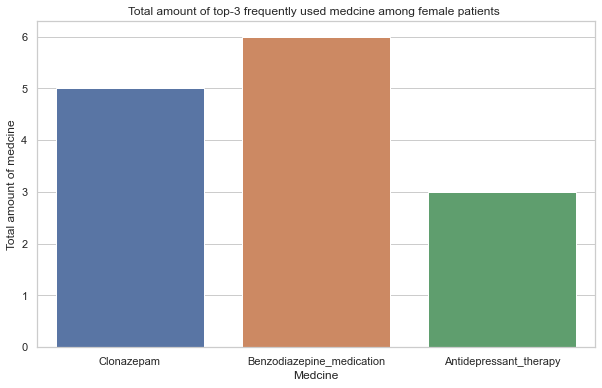

In [444]:
plt.figure(figsize=(10,6))

# Add title
plt.title("Total amount of top-3 frequently used medcine among female patients ")

# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.set_theme(style="whitegrid")
sns.barplot(x='Medcine', y='count',data = medcine_df.toPandas())

# Add label for vertical axis
plt.ylabel("Total amount of medcine")